In [1]:
from datasets import load_dataset

# Path to your JSON files
data_files = {
    "train": "train.json",
    "validation": "validation.json",
    "test": "test.json",
}

# Load the dataset
dataset = load_dataset("json", data_files=data_files)

# Inspect the dataset
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 400
    })
    test: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 1500
    })
})


In [2]:
example = dataset['train'][0]
example

{'ID': '2017-En-21618',
 'Tweet': '@Chic_Happens_ @Sean_Okeeffe1 @royalmusing I dread the comparisons to Queen Máxima. Guarantee I will lose followers when that happens.',
 'anger': False,
 'anticipation': False,
 'disgust': True,
 'fear': True,
 'joy': False,
 'love': False,
 'optimism': False,
 'pessimism': True,
 'sadness': False,
 'surprise': False,
 'trust': False}

In [3]:
labels = [label for label in dataset['train'].features.keys() if label not in ['ID', 'Tweet']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

In [4]:
from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_data(examples):
  # take a batch of texts
  text = examples["Tweet"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  
  return encoding

In [5]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [6]:
example = encoded_dataset['train'][0]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [7]:
tokenizer.decode(example['input_ids'])

'[CLS] @ chic _ happens _ @ sean _ okeeffe1 @ royalmusing i dread the comparisons to queen maxima. guarantee i will lose followers when that happens. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [8]:
example['labels']

[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]

In [9]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['disgust', 'fear', 'pessimism']

In [10]:
encoded_dataset.set_format("torch")

In [11]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
batch_size = 8
metric_name = "f1"

In [13]:
from transformers import TrainingArguments

args = TrainingArguments(
    f"bert-finetuned-sem_eval-english",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

c:\Users\Lenovo\anaconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
    
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [15]:
encoded_dataset['train'][0]['labels'].type()

'torch.FloatTensor'

In [16]:
encoded_dataset['train']['input_ids'][0]

tensor([  101,  1030,  9610,  2278,  1035,  6433,  1035,  1030,  5977,  1035,
         7929,  4402, 16020,  2487,  1030,  2548,  7606,  2075,  1045, 14436,
         1996, 18539,  2000,  3035, 20446,  2050,  1012, 11302,  1045,  2097,
         4558,  8771,  2043,  2008,  6433,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [17]:
outputs = model(input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0), labels=encoded_dataset['train'][0]['labels'].unsqueeze(0))
outputs

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


SequenceClassifierOutput(loss=tensor(0.6522, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[-0.0355, -0.1998, -0.3990,  0.0799, -0.3164,  0.2164,  0.1829,  0.6490,
         -0.3140,  0.1236, -0.5244]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [19]:
from transformers import Trainer
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14892\2938580022.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
trainer.train()

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.35279181599617004, 'eval_f1': 0.6374845869297164, 'eval_roc_auc': 0.7464143487827605, 'eval_accuracy': 0.2375, 'eval_runtime': 60.7108, 'eval_samples_per_second': 6.589, 'eval_steps_per_second': 0.824, 'epoch': 1.0}
{'loss': 0.3969, 'grad_norm': 0.8815603256225586, 'learning_rate': 1.4666666666666666e-05, 'epoch': 1.33}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.32612666487693787, 'eval_f1': 0.6651053864168618, 'eval_roc_auc': 0.7675154469779464, 'eval_accuracy': 0.255, 'eval_runtime': 64.785, 'eval_samples_per_second': 6.174, 'eval_steps_per_second': 0.772, 'epoch': 2.0}
{'loss': 0.294, 'grad_norm': 1.4121776819229126, 'learning_rate': 9.333333333333334e-06, 'epoch': 2.67}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.3117184638977051, 'eval_f1': 0.6868451688009313, 'eval_roc_auc': 0.7805714909501387, 'eval_accuracy': 0.28, 'eval_runtime': 60.4369, 'eval_samples_per_second': 6.618, 'eval_steps_per_second': 0.827, 'epoch': 3.0}
{'loss': 0.2416, 'grad_norm': 1.6701103448867798, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.3171573877334595, 'eval_f1': 0.6911349520045172, 'eval_roc_auc': 0.7873538261391387, 'eval_accuracy': 0.2875, 'eval_runtime': 67.9706, 'eval_samples_per_second': 5.885, 'eval_steps_per_second': 0.736, 'epoch': 4.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.3175458610057831, 'eval_f1': 0.6908267270668177, 'eval_roc_auc': 0.7867637775227316, 'eval_accuracy': 0.28, 'eval_runtime': 61.7921, 'eval_samples_per_second': 6.473, 'eval_steps_per_second': 0.809, 'epoch': 5.0}
{'train_runtime': 9779.1636, 'train_samples_per_second': 1.534, 'train_steps_per_second': 0.192, 'train_loss': 0.2921791015625, 'epoch': 5.0}


TrainOutput(global_step=1875, training_loss=0.2921791015625, metrics={'train_runtime': 9779.1636, 'train_samples_per_second': 1.534, 'train_steps_per_second': 0.192, 'total_flos': 986746187520000.0, 'train_loss': 0.2921791015625, 'epoch': 5.0})

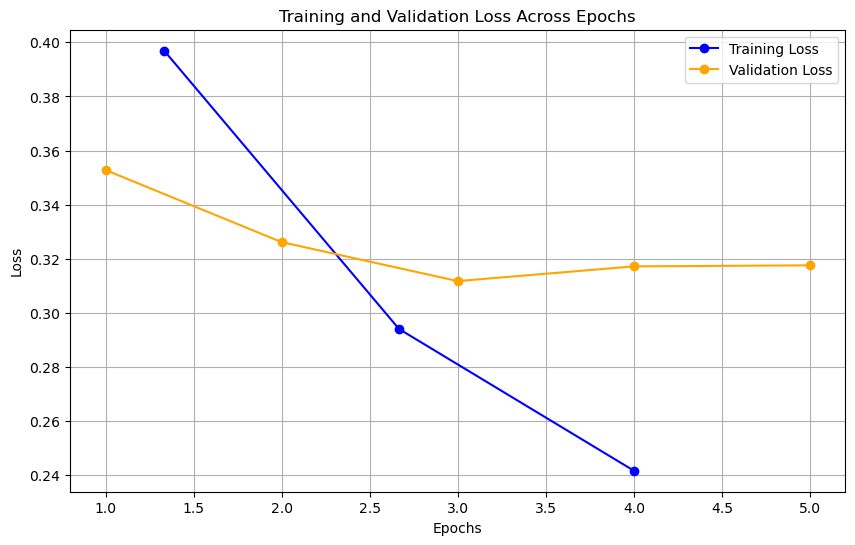

In [25]:
import matplotlib.pyplot as plt

# Extract data directly from trainer.state.log_history
log_history = trainer.state.log_history

# Extract epochs, training losses, and evaluation losses
epochs = sorted(set(entry['epoch'] for entry in log_history if 'epoch' in entry))  # Ensure unique epochs
train_losses = []
eval_losses = []

for epoch in epochs:
    train_loss = next((entry['loss'] for entry in log_history if entry.get('epoch') == epoch and 'loss' in entry), None)
    eval_loss = next((entry['eval_loss'] for entry in log_history if entry.get('epoch') == epoch and 'eval_loss' in entry), None)
    train_losses.append(train_loss)
    eval_losses.append(eval_loss)

# Remove None values for plotting
valid_epochs_train = [e for e, loss in zip(epochs, train_losses) if loss is not None]
valid_train_losses = [loss for loss in train_losses if loss is not None]

valid_epochs_eval = [e for e, loss in zip(epochs, eval_losses) if loss is not None]
valid_eval_losses = [loss for loss in eval_losses if loss is not None]

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(valid_epochs_train, valid_train_losses, label="Training Loss", marker='o', color='blue')
plt.plot(valid_epochs_eval, valid_eval_losses, label="Validation Loss", marker='o', color='orange')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid()
plt.show()


In [26]:
trainer.evaluate()

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.3171573877334595,
 'eval_f1': 0.6911349520045172,
 'eval_roc_auc': 0.7873538261391387,
 'eval_accuracy': 0.2875,
 'eval_runtime': 60.2137,
 'eval_samples_per_second': 6.643,
 'eval_steps_per_second': 0.83,
 'epoch': 5.0}

In [32]:
import json
import torch
import numpy as np

with open("test.json", "r") as f:
    test_data = [json.loads(line) for line in f]

sigmoid = torch.nn.Sigmoid()

true_labels = []
predictions_all = []

for example in test_data:
    text = example['Tweet']
    encoding = tokenizer(text, return_tensors="pt")
    encoding = {k: v.to(model.device) for k, v in encoding.items()}

    outputs = model(**encoding)
    logits = outputs.logits

    probs = sigmoid(logits.squeeze().cpu()).detach().numpy()
    
    predictions = np.zeros(probs.shape)
    predictions[np.where(probs >= 0.5)] = 1
    
    predicted_labels = [id2label[idx] for idx in range(len(predictions)) if predictions[idx] == 1.0]
    true_labels_example = [label for label, value in example.items() if label != 'Tweet' and value]
    
    true_labels.append(true_labels_example)
    predictions_all.append(predicted_labels)

def exact_match_accuracy(true_labels, predictions):
    exact_match = 0
    for true, pred in zip(true_labels, predictions):
        if sorted(true) == sorted(pred): 
            exact_match += 1
    return exact_match / len(true_labels)

def partial_match_accuracy(true_labels, predictions):
    partial_match = 0
    for true, pred in zip(true_labels, predictions):
        if any(label in true for label in pred): 
            partial_match += 1
    return partial_match / len(true_labels)

exact_match_acc = exact_match_accuracy(true_labels, predictions_all)
partial_match_acc = partial_match_accuracy(true_labels, predictions_all)

print(f"Exact Match Accuracy (i.e., all labels must match): {exact_match_acc:.4f}")
print(f"Partial Match Accuracy(prediction is correct as long as one label matches.): {partial_match_acc:.4f}")


Exact Match Accuracy (i.e., all labels must match): 0.0000
Partial Match Accuracy(prediction is correct as long as one label matches.): 0.8567
